In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
import seaborn as sns
from DS_models_stat import stat_orig_cats, do_all_stats, stat_orig_cats_simple
from DS_detector import rematch_cat
from matplotlib.ticker import LinearLocator
from DS_healpix_fragmentation import cut_cat_by_pix
from DS_data_transformation import this_ax

In [2]:
max_pred_unite = np.arange(0.1, 1, 0.05)
max_found_val = 250

In [3]:
def this_ax1(ax, max_pred_unite, ylim=[0, 1.05], yticks=[0.1, 1.1, 0.1]):
    l = ax.axvline(8.0, c='brown', linestyle='-.')
    l.set_label('s/n=8.0')
    ax.set_xlabel('s/n')
    ax.set_xticks(max_pred_unite, minor=True)
    ax.set_xticks(max_pred_unite[::5], minor=False)
    ax.set_xlim(5.4, 10.1)
    
    ax.set_ylim(*ylim)
    
    ax.set_yticks(np.arange(*yticks), minor=False)
    #ax.set_yticks(np.arange(*yticks)[::2], minor=False)
    
    ax.grid(True, axis='both', which='major', linestyle=':')
    ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
    #plt.xscale('log')
    ax.set_xscale('log')
    ax.legend()

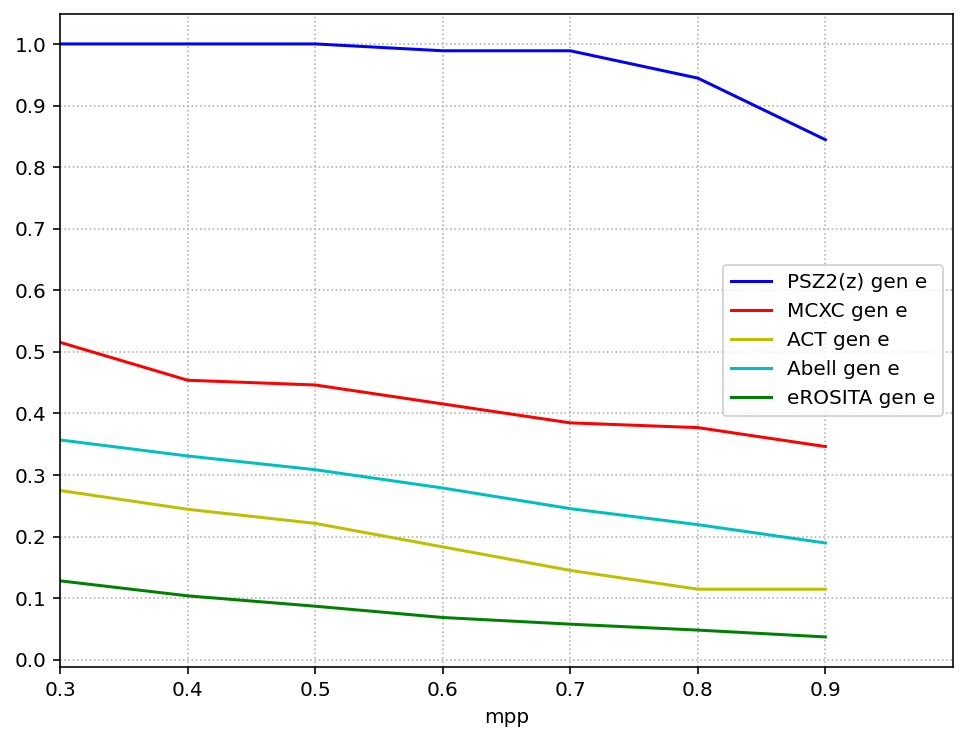

In [118]:
def show_prm(ax, pixname, selected_det, selected_tr, index_name='max_pred', dirname='./check/', ylabel='', xlim=[0, 1], xticks=None,
            only_plot=False, colors='brycg', found_mode=False, coef=1.0):
    #cats = ['SZcat(base)',  'SZcat(AL)', 'brcat', 'gen', 'SZcat(AL)_unique', 'inter', 'brcat_unique']
    recalls = {name : pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(name, pixname), index_col=index_name)
                  for name in selected_det}

    for c, name_tr in zip(colors, selected_tr):
        for name_det, st in zip(recalls, ['-', '--']):
            df = recalls[name_det]
            s, = ax.plot(df.index, df[name_tr] * coef, c=c, linestyle=st)
            s.set_label(name_tr + ' ' + name_det + ' ' + pixname)
    if not only_plot:
        ax.set_ylabel(ylabel)
        ax.set_xlabel(index_name)

        if xticks is None:
            xticks = df.index
        ax.set_xticks(xticks, minor=False)
        ax.set_xlim(xlim)
        
        if not found_mode:
            ax.set_yticks(np.arange(0, 1.1, 0.1), minor=False)
        else:
            ax.set_yticks(np.arange(0, 200, 50))
            ax.set_ylim(0, 200)

        ax.grid(True, axis='both', which='major', linestyle=':')
        ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
        ax.legend()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
#show_prm(ax, 'e', selected_det=['brcat'], selected_tr=['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'],
           #index_name='s/n', dirname='./check/', xlim=[5.0, 10.1])
show_prm(ax, 'e', selected_det=['gen'], selected_tr=['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'],
           index_name='mpp', dirname='./check/', xlim=[0.3, 1])

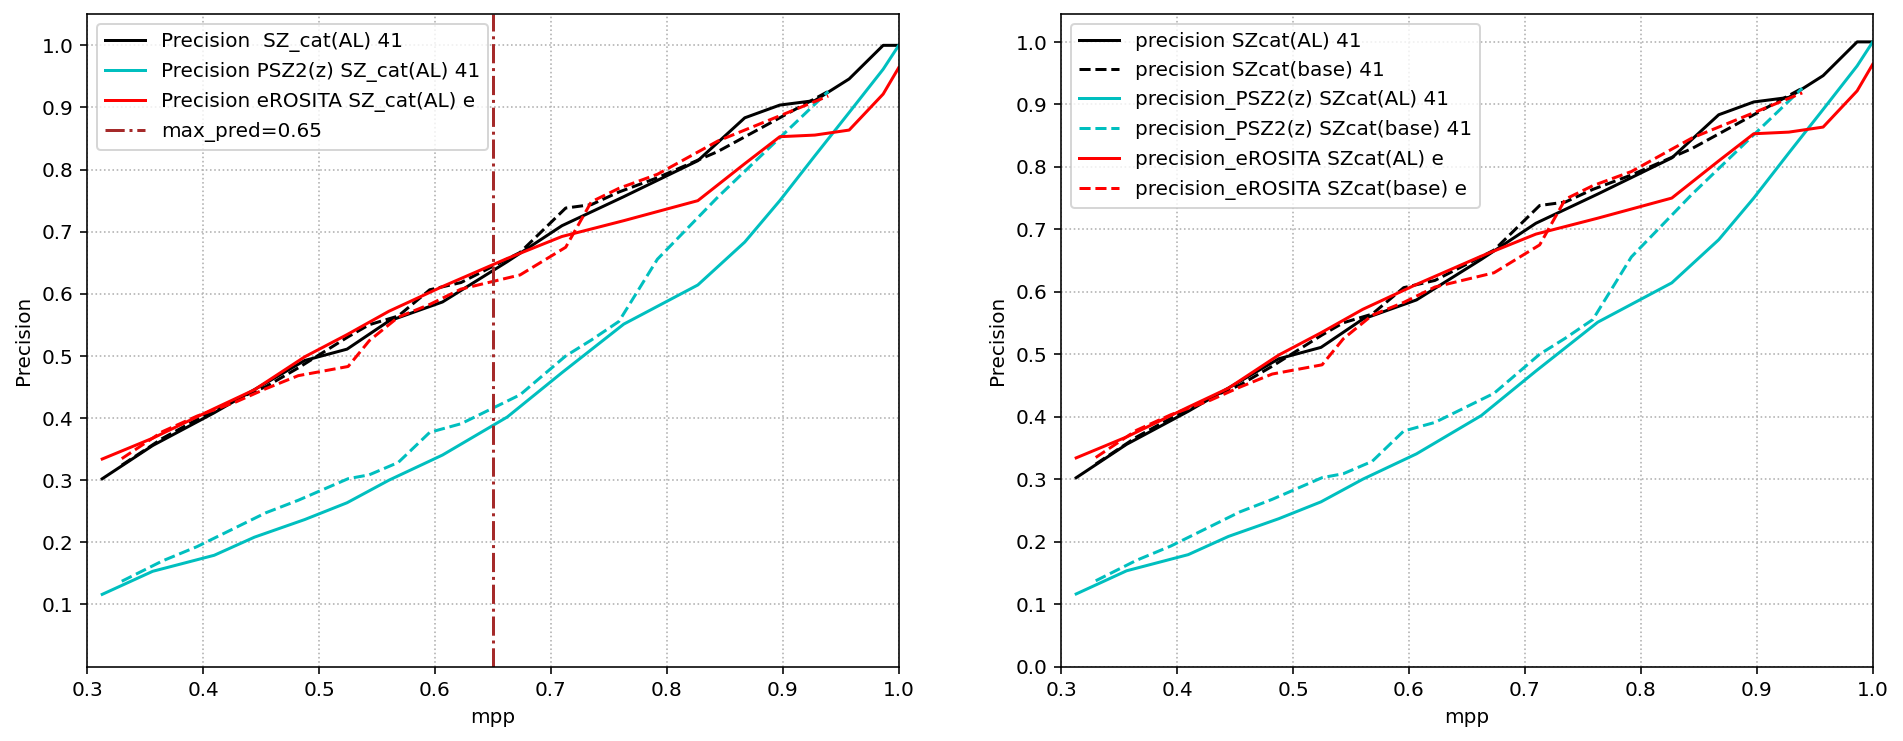

In [74]:
find_precision=0.8

def show_precision(ax, show_basic, unique_mode=False, unique_mode_br=False, mpp_mode=False):

    def plot_precision(ax, pixname, show_basic, selected, colors='kcr', unique_mode=False, unique_mode_br=False, mpp_mode=False):
        base_cat_name = 'SZ_cat(basic)'
        al_cat_name = 'SZ_cat(AL)'
        dirname = './check/'
        index_name = 'max_pred'
        if mpp_mode:
            dirname = './check/mpp/'
            index_name = 'mpp'
        recalls = {al_cat_name : pd.read_csv(dirname+'all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col=index_name),
             base_cat_name : pd.read_csv(dirname+'pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col=index_name)
        }
        if unique_mode:
            uname = 'all_found_unique'
            iname = 'inter'
            recalls = {uname : pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(uname, pixname), index_col=index_name),
                      iname: pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(iname, pixname), index_col=index_name)}
        if unique_mode_br:
            uname = 'brcat_unique'
            iname = 'inter_sn'
            recalls = {uname : pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(uname, pixname), index_col=index_name),
                      iname: pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(iname, pixname), index_col=index_name)}
        for name_cat, st in zip(recalls, ['-', '--']):
            if not show_basic and name_cat == base_cat_name:
                continue
            df = recalls[name_cat]
            for prec, c in zip(selected, colors):
                prm = 'precision' if prec == '' else 'precision_' + prec
                s, = ax.plot(df.index, df[prm], c=c, linestyle=st)
                if name_cat != base_cat_name:
                    s.set_label('Precision '+ prec + ' ' + name_cat + ' ' + pixname)
            
        if '' in selected:
            text = ''
            for name_cat in recalls:
                df = recalls[name_cat]
                idx = np.abs(df['precision'] - find_precision).argmin()
                mp = np.array(df.index)[idx]
                text += '{} max_pred={:.2f} prec={:.4f}'.format(name_cat, mp, df['precision'][mp]) + '\n'
            #ax.text(s=text, x=0.5, y=0.1)
        return recalls[list(recalls.keys())[0]].index, index_name

    index, index_name = plot_precision(ax, pixname='41', show_basic=show_basic, selected=['', 'PSZ2(z)'], unique_mode=unique_mode, 
                   unique_mode_br=unique_mode_br, mpp_mode=mpp_mode)            
    plot_precision(ax, pixname='e', show_basic=show_basic, selected=['eROSITA'], colors='r', unique_mode=unique_mode, 
                   unique_mode_br=unique_mode_br, mpp_mode=mpp_mode)
    ax.set_ylabel('Precision')
    if unique_mode_br:
        this_ax1(ax, index)
    else:
        if mpp_mode:
            this_ax(ax, xtitle=index_name, xlim=[0.3, 1.0])
        else:
            this_ax(ax, xtitle=index_name)
    
_, ax = plt.subplots(1, 2, figsize=(16, 6))
show_precision(ax[0], True, mpp_mode=True)        
show_prm(ax[1], selected_det=['SZcat(AL)', 'SZcat(base)'], selected_tr=['precision', 'precision_PSZ2(z)'], pixname='41', only_plot=True, colors='kc', 
         dirname='./check/mpp/', index_name='mpp', xlim=[0.3, 1])
show_prm(ax[1], selected_det=['SZcat(AL)', 'SZcat(base)'], selected_tr=['precision_eROSITA'], pixname='e', colors='r', dirname='./check/mpp/',
        index_name='mpp', xlim=[0.3, 1], xticks=np.arange(0.3, 1.1, 0.1), ylabel='Precision')

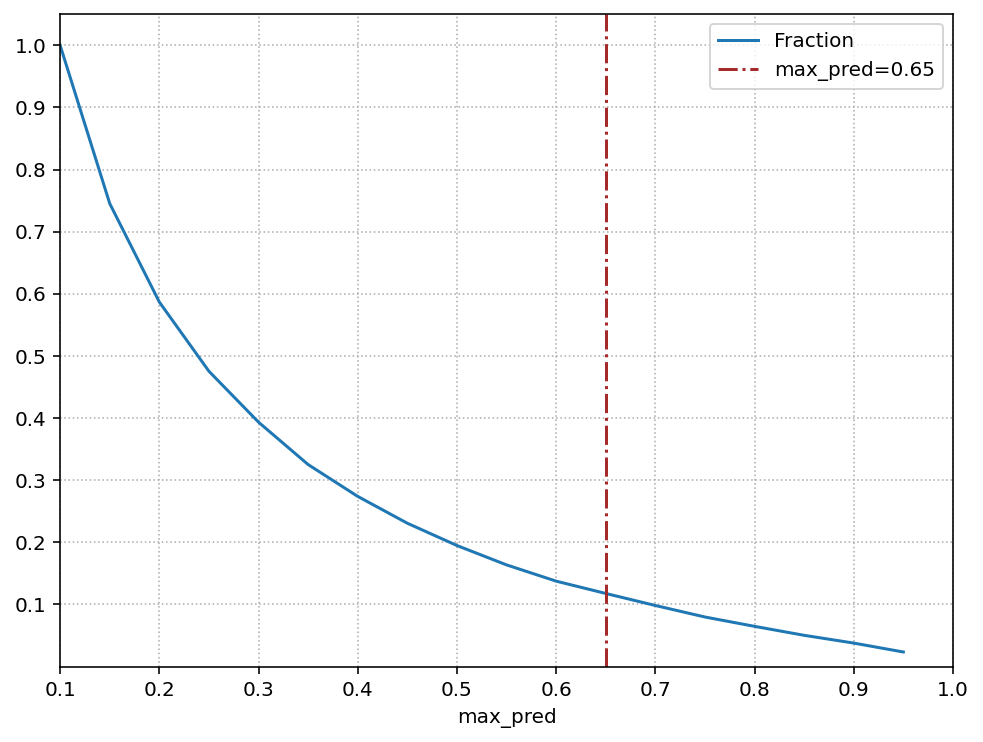

In [6]:
#fraction
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
fraction = []
for val in max_pred_unite:
    fraction.append(np.count_nonzero(df['max_pred'] >= val) / len(df))

_, ax = plt.subplots(1, 1, figsize=(8, 6))
l, = ax.plot(max_pred_unite, fraction)
l.set_label('Fraction')
this_ax(ax)

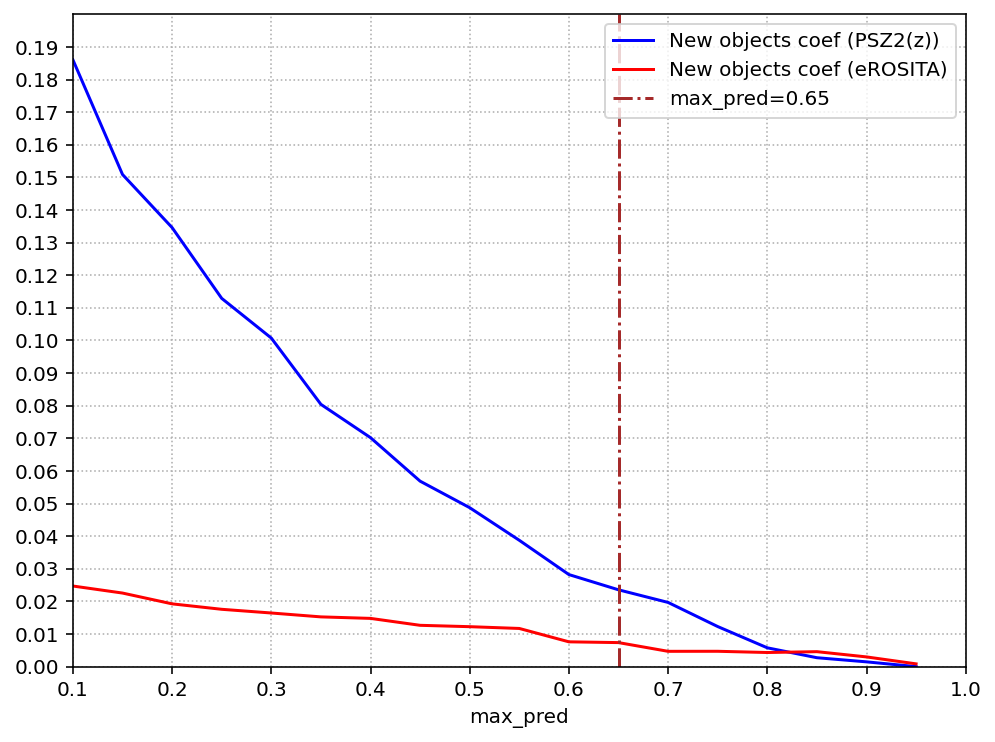

In [7]:
def get_precision_dif(pixname, cat='PSZ2(z)'):
    recall = pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    return recall['precision'] - recall['precision_'+cat]

_, ax = plt.subplots(1, 1, figsize=(8, 6))
precision_dif = get_precision_dif(pixname='41')
l, = ax.plot(max_pred_unite, precision_dif * fraction, c='b')
l.set_label('New objects coef (PSZ2(z))')
precision_dif = get_precision_dif(pixname='e', cat='eROSITA')
precision_dif = np.clip(precision_dif, 0, 1)
l, = ax.plot(max_pred_unite, precision_dif * fraction, c='r')
l.set_label('New objects coef (eROSITA)')
this_ax(ax, ylim=[0, 0.2], yticks=[0, 0.2, 0.01])

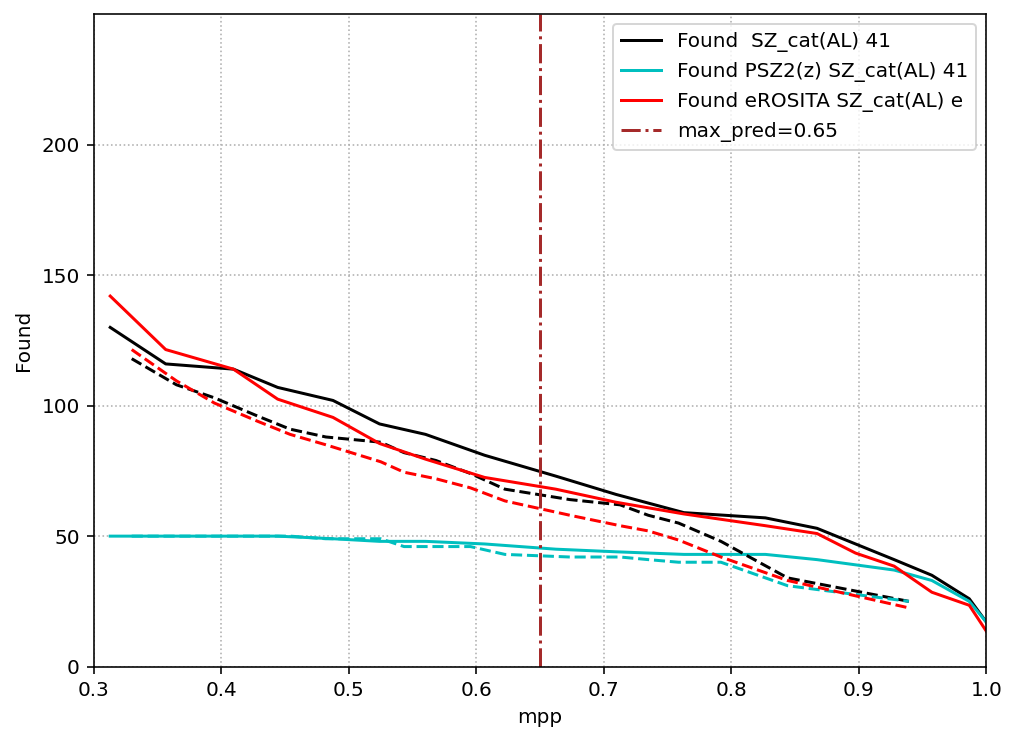

In [90]:
def show_found(ax,show_basic, unique_mode=False, unique_mode_br=False, mpp_mode=False):
    
    def plot_found(ax, pixname, show_basic, selected, colors='kcr', coef=1.0, unique_mode=False, unique_mode_br=False, mpp_mode=False):
        base_cat_name = 'SZ_cat(basic)'
        al_cat_name = 'SZ_cat(AL)'
        dirname = './check/'
        index_name = 'max_pred'
        if mpp_mode:
            dirname = './check/mpp/'
            index_name = 'mpp'
        recalls = {al_cat_name : pd.read_csv(dirname+'all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col=index_name),
             base_cat_name : pd.read_csv(dirname+'pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col=index_name)
        }
        if unique_mode:
            uname = 'all_found_unique'
            iname = 'inter'
            recalls = {uname : pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(uname, pixname), index_col=index_name),
                      iname: pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(iname, pixname), index_col=index_name)}
        if unique_mode_br:
            uname = 'brcat_unique'
            iname = 'inter_sn'
            recalls = {uname : pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(uname, pixname), index_col=index_name),
                      iname: pd.read_csv(dirname+'{}_recall_max_pred_pix{}.csv'.format(iname, pixname), index_col=index_name)}
        for name_cat, st in zip(recalls, ['-', '--']):
            df = recalls[name_cat]
            for prec, c in zip(selected, colors):
                prm = 'found' if prec == '' else 'found_' + prec
                s, = ax.plot(df.index, df[prm] * coef, c=c, linestyle=st)
                if name_cat != base_cat_name:
                    s.set_label('Found '+ prec + ' ' + name_cat + ' ' + pixname)
        return recalls[list(recalls.keys())[0]].index, index_name

    show_basic = True 

    index, index_name = plot_found(ax, pixname='41', show_basic=show_basic, selected=['', 'PSZ2(z)'], coef=1.0, unique_mode=unique_mode, 
                   unique_mode_br=unique_mode_br, mpp_mode=mpp_mode)            
    plot_found(ax, pixname='e', show_basic=show_basic, selected=['eROSITA'], colors='r', coef=1/2, unique_mode=unique_mode, 
                   unique_mode_br=unique_mode_br, mpp_mode=mpp_mode)            

    ax.set_ylabel('Found')
    if unique_mode_br:
        this_ax1(ax, index, ylim=[0, max_found_val], yticks=[0, max_found_val, 50])
    else:
        if mpp_mode:
            this_ax(ax, ylim=[0, max_found_val], yticks=[0, max_found_val, 50], xtitle=index_name, xlim=[0.3, 1.0])
        else:
            this_ax(ax, ylim=[0, max_found_val], yticks=[0, max_found_val, 50])
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_found(ax, True, mpp_mode=True)

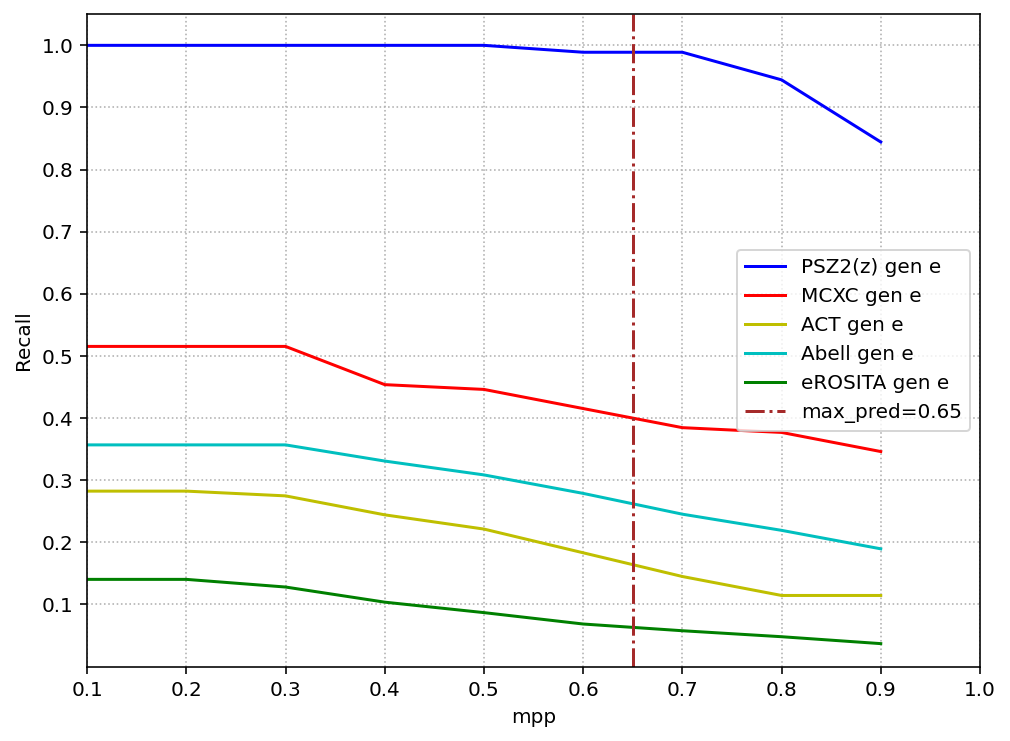

In [91]:
def show_recall_br(ax, pixname, selected, gen_mode=False, unique_mode=False):
    det_name='brcat'
    if gen_mode:
        det_name='gen'
    df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])

    for c, name in zip('brycg', selected):
        s, = ax.plot(df.index, df[name], c=c, linestyle='-')
        s.set_label(name + ' ' + det_name + ' ' + pixname)
    ax.set_ylabel('Recall')
    if gen_mode:
        this_ax(ax, xtitle='mpp')
    else:
        this_ax1(ax, df.index)

_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_recall_br(ax, 'e', ['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'], gen_mode=True)

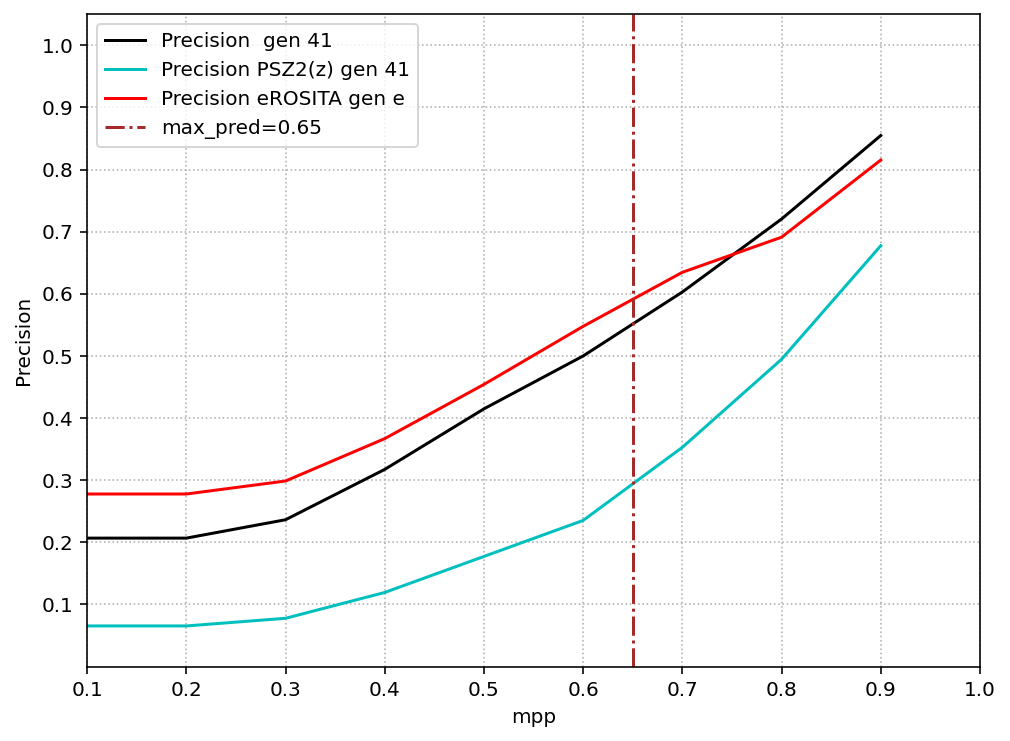

In [92]:
def show_precision_br(ax, gen_mode=False):
    def plot_precision(ax, pixname, selected, colors='kcr'):
        det_name='brcat'
        if gen_mode:
            det_name='gen'
        df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])
        for prec, c in zip(selected, colors):
            prm = 'precision' if prec == '' else 'precision_' + prec
            s, = ax.plot(df.index, df[prm], c=c, linestyle='-')
            s.set_label('Precision '+ prec + ' ' + det_name+ ' ' + pixname)
            
        if '' in selected:
            idx = np.abs(df['precision'] - find_precision).argmin()
            mp = np.array(df.index)[idx]
            text = '{} s/n={:.2f} prec={:.4f}'.format(det_name, mp, df['precision'][mp]) + '\n'
            #ax.text(s=text, x=6, y=0.1)
        return df.index

    index = plot_precision(ax, pixname='41', selected=['', 'PSZ2(z)'])            
    plot_precision(ax, pixname='e', selected=['eROSITA'], colors='r')

    ax.set_ylabel('Precision')
    if gen_mode:
        this_ax(ax, xtitle='mpp')
    else:
        this_ax1(ax, index)
    
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_precision_br(ax, gen_mode=True)

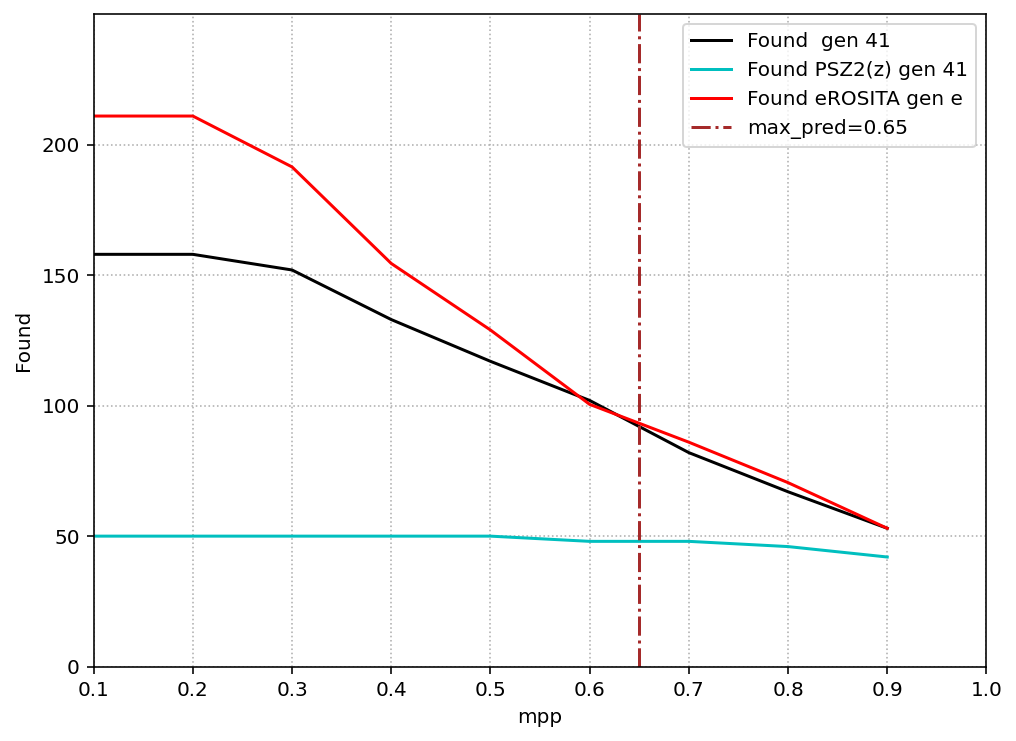

In [93]:
def show_found_br(ax, gen_mode=False):
    
    def plot_found_br(ax, pixname, selected, colors='kcr', coef=1.0):
        det_name='brcat'
        if gen_mode:
            det_name = 'gen'
        df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])
        for prec, c in zip(selected, colors):
            prm = 'found' if prec == '' else 'found_' + prec
            s, = ax.plot(df.index, df[prm] * coef, c=c, linestyle='-')
            s.set_label('Found '+ prec + ' ' + det_name + ' ' + pixname)
        return df.index


    index = plot_found_br(ax, pixname='41', selected=['', 'PSZ2(z)'], coef=1.0)            
    plot_found_br(ax, pixname='e', selected=['eROSITA'], colors='r', coef=1/2)            

    ax.set_ylabel('Found')
    if gen_mode:
        this_ax(ax, ylim=[0, max_found_val], yticks=[0, max_found_val, 50], xtitle='mpp')
    else:
        this_ax1(ax, ylim=[0, max_found_val], yticks=[0, max_found_val, 50], max_pred_unite=index)
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_found_br(ax, True)

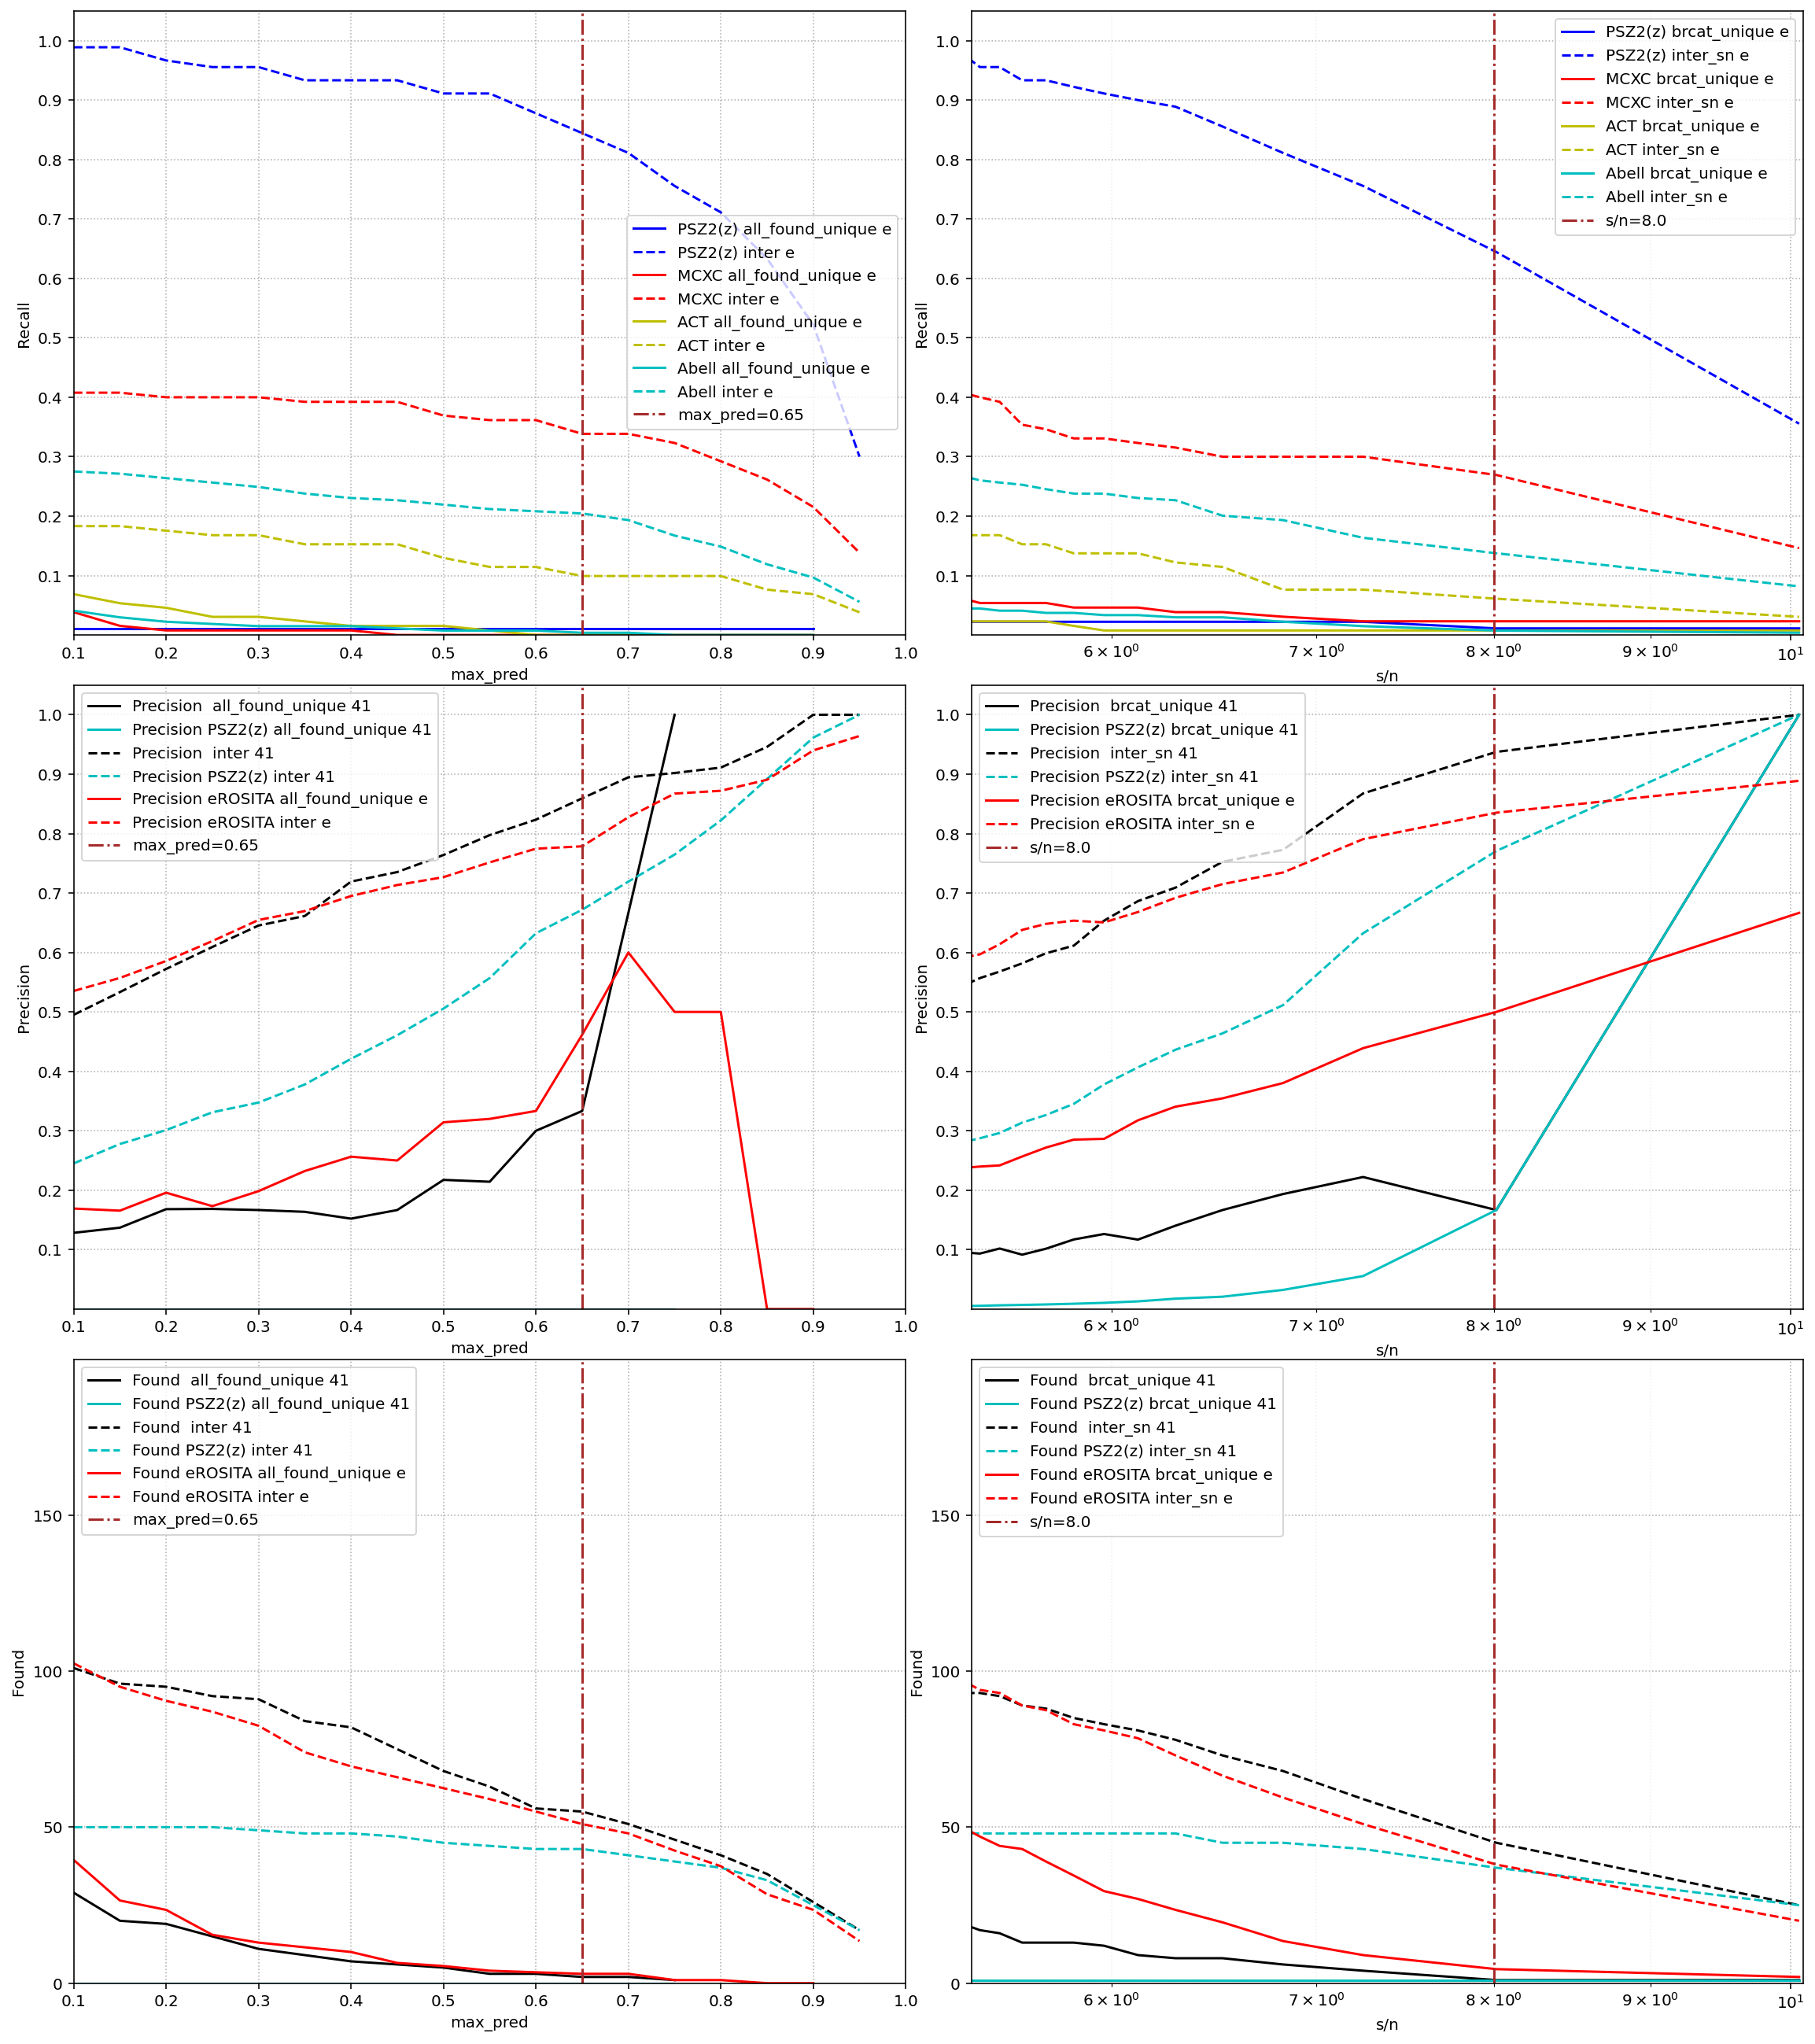

In [38]:
_, ax = plt.subplots(3, 2, figsize=(16, 18), sharey=False)
plt.tight_layout()
show_recall(ax[0][0], 'e', True, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'], uniq_mode=True)
show_recall(ax[0][1], 'e', True, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'], uniq_mode_br=True)

show_precision(ax[1][0], True, unique_mode=True)        
show_precision(ax[1][1], True, unique_mode_br=True)        

show_found(ax[2][0], True, unique_mode=True)
show_found(ax[2][1], True, unique_mode_br=True)

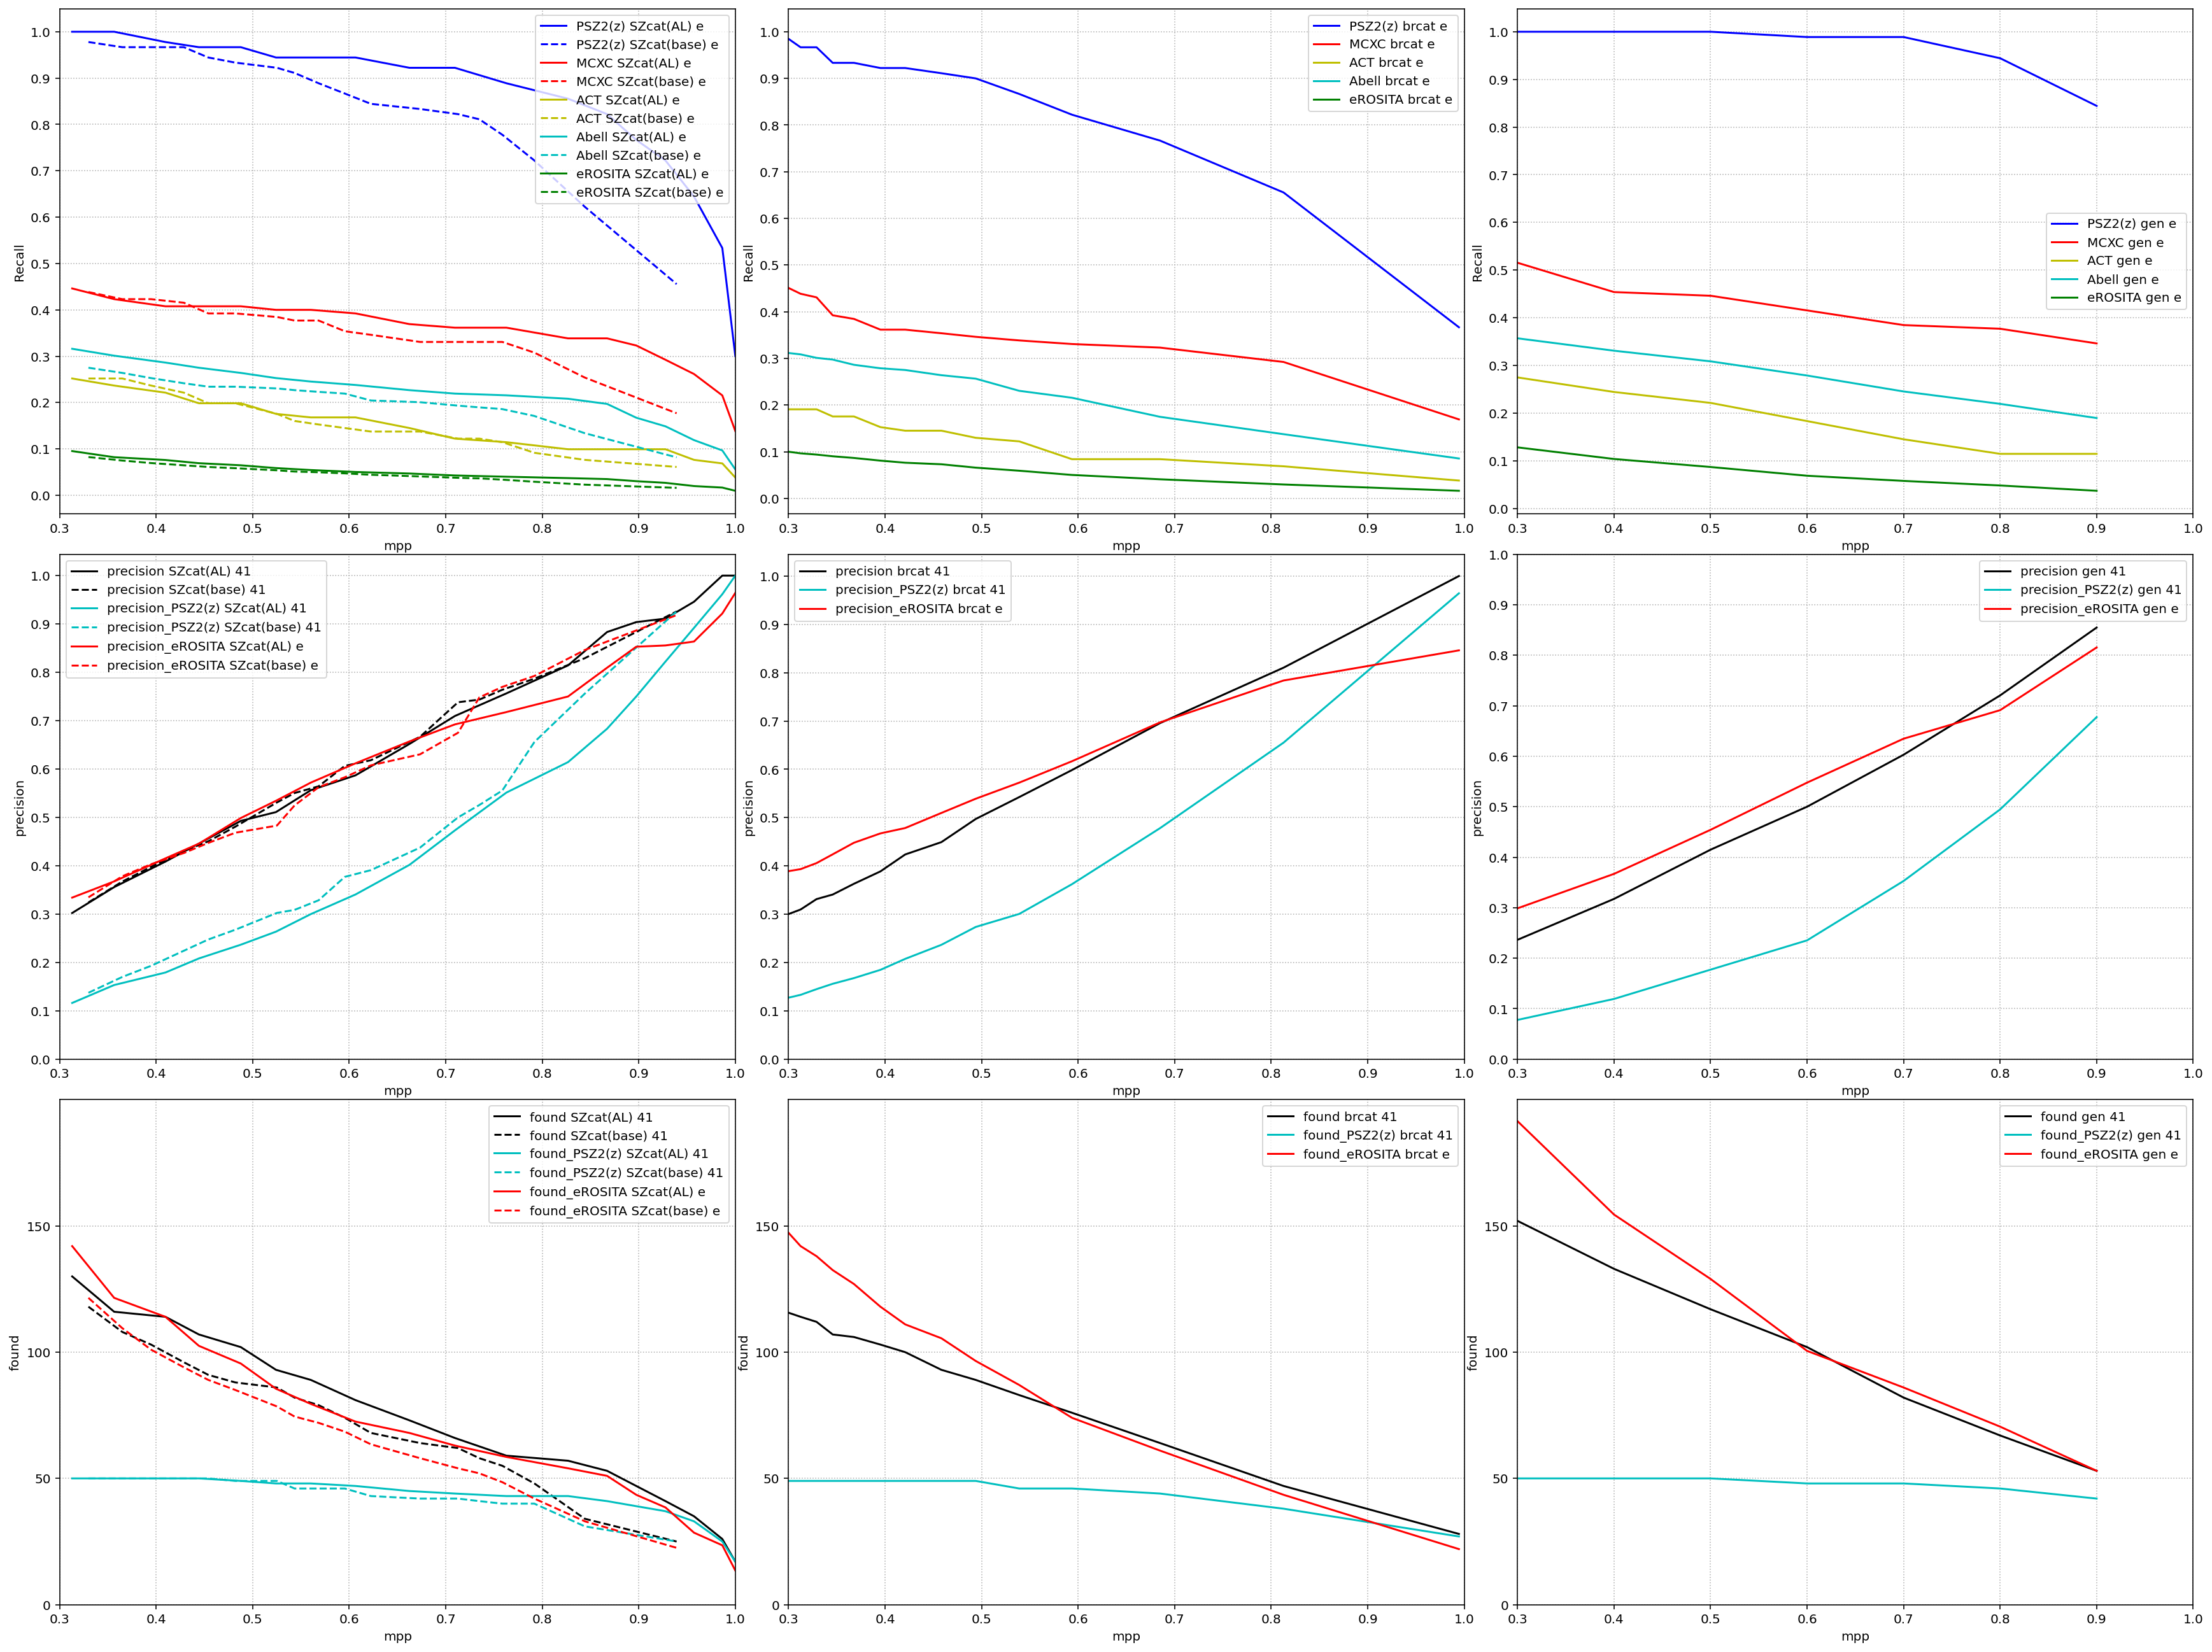

In [119]:
_, ax = plt.subplots(3, 3, figsize=(24, 18), sharey=False)
plt.tight_layout()
selected_tr = ['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA']
pixname='e'
xticks=np.arange(0.1, 1.1, 0.1)
xlim=[0.3, 1.0]
ylabel='Recall'
index_name='mpp'
dirname='./check/mpp/'
for i, selected_det in enumerate((['SZcat(AL)', 'SZcat(base)'], ['brcat'], ['gen'])):
    show_prm(ax[0][i], pixname, selected_tr=selected_tr, selected_det=selected_det, xticks=xticks, xlim=xlim, ylabel=ylabel, 
             index_name=index_name, dirname=dirname)
    for j, prm in enumerate(['precision', 'found']):
        coef=1.0
        show_prm(ax[1+j][i], '41', selected_det=selected_det, selected_tr=[prm, prm+'_PSZ2(z)'], colors='kc', only_plot=True, 
                 index_name=index_name, dirname=dirname)
        if prm == 'found':
            coef=1/2
        show_prm(ax[1+j][i], 'e', selected_det=selected_det, selected_tr=[prm+'_eROSITA'], colors='r', 
                 index_name=index_name, dirname=dirname, xticks=xticks, xlim=xlim, ylabel=prm, found_mode=prm=='found', coef=coef)


In [ ]:
_, ax = plt.subplots(3, 2, figsize=(16, 18), sharey=False)
plt.tight_layout()


#show_recall(ax[0][0], 'e', True, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'], uniq_mode=True)
show_recall(ax[0][1], 'e', True, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'], uniq_mode_br=True)

show_precision(ax[1][0], True, unique_mode=True)        
show_precision(ax[1][1], True, unique_mode_br=True)        

show_found(ax[2][0], True, unique_mode=True)
show_found(ax[2][1], True, unique_mode_br=True)